# Data Science Regression Project: Predicting Home Prices in Banglore

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

## Data Load: Load banglore home prices into a dataframe

In [4]:
df1 = pd.read_csv("Bengaluru_House_Data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [5]:
df1.shape

(13320, 9)

In [6]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [7]:
df1['area_type'].unique()


array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [8]:
df1['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

### Drop features that are not required to build our model

In [9]:
df2 = df1.drop(['area_type','society','availability'],axis='columns')
df2.shape

(13320, 6)

## Data Cleaning: Handle NA values

In [10]:
df2.isnull().sum()

location        1
size           16
total_sqft      0
bath           73
balcony       609
price           0
dtype: int64

In [11]:
df2.shape


(13320, 6)

In [12]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
balcony       0
price         0
dtype: int64

In [13]:
df3.shape

(12710, 6)

## Feature Engineering

##### Add new feature(integer) for bhk (Bedrooms Hall Kitchen)

In [14]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

C:\Users\Hp\AppData\Local\Temp\ipykernel_11792\2716584372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  1,  6,  8,  7,  5, 11,  9, 27, 43, 14, 12, 10, 13],
      dtype=int64)

#### Explore total_sqft feature

In [15]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [16]:
df3[~df3['total_sqft'].apply(is_float)]

,location,size,total_sqft,bath,balcony,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,0.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,0.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,0.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,0.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,0.0,56.800,2
...,...,...,...,...,...,...,...
12975,Whitefield,2 BHK,850 - 1060,2.0,0.0,38.190,2
12990,Talaghattapura,3 BHK,1804 - 2273,3.0,0.0,122.000,3
13059,Harlur,2 BHK,1200 - 1470,2.0,0.0,72.760,2
13265,Hoodi,2 BHK,1133 - 1384,2.0,0.0,59.135,2


##### Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [17]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None 

In [18]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4

,location,size,total_sqft,bath,balcony,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2
...,...,...,...,...,...,...,...
13314,Green Glen Layout,3 BHK,1715.0,3.0,3.0,112.00,3
13315,Whitefield,5 Bedroom,3453.0,4.0,0.0,231.00,5
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,1.0,60.00,2
13318,Padmanabhanagar,4 BHK,4689.0,4.0,1.0,488.00,4


# Feature Engineering

#### Adding new feature called price per square feet

In [19]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5

,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...,...
13314,Green Glen Layout,3 BHK,1715.0,3.0,3.0,112.00,3,6530.612245
13315,Whitefield,5 Bedroom,3453.0,4.0,0.0,231.00,5,6689.834926
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,1.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,1.0,488.00,4,10407.336319


In [20]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.266800e+04
mean     6.876277e+03
std      2.263354e+04
min      2.678298e+02
25%      4.242721e+03
50%      5.376344e+03
75%      7.142857e+03
max      2.300000e+06
Name: price_per_sqft, dtype: float64

#### Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [21]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

Whitefield           514
Sarjapur  Road       372
Electronic City      302
Kanakpura Road       259
Thanisandra          233
                    ... 
Subbannaiah Palya      1
whitefiled             1
Medi Agrahara          1
Sadduguntepalya        1
Abshot Layout          1
Name: location, Length: 1248, dtype: int64

In [22]:
location_stats.values.sum()

12668

In [23]:
len(location_stats[location_stats>10])

235

In [24]:
len(location_stats)

1248

In [25]:
len(location_stats[location_stats<=10])

1013

## Dimensionality Reduction
##### Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [26]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Nagappa Reddy Layout     10
Dairy Circle             10
                         ..
Subbannaiah Palya         1
whitefiled                1
Medi Agrahara             1
Sadduguntepalya           1
Abshot Layout             1
Name: location, Length: 1013, dtype: int64

In [27]:
len(df5.location.unique())

1248

In [28]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

236

## Outlier Removal Using Business Logic
#### As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [29]:
df5[df5.total_sqft/df5.bhk<300]

,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
58,Murugeshpalya,6 Bedroom,1407.0,4.0,1.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,0.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,2.0,100.0,3,20000.000000
78,Kaval Byrasandra,2 BHK,460.0,1.0,0.0,22.0,2,4782.608696
89,Rajaji Nagar,6 Bedroom,710.0,6.0,3.0,160.0,6,22535.211268
...,...,...,...,...,...,...,...,...
13219,Laggere,7 Bedroom,1590.0,9.0,3.0,132.0,7,8301.886792
13221,other,9 Bedroom,1178.0,9.0,1.0,75.0,9,6366.723260
13281,Margondanahalli,5 Bedroom,1375.0,5.0,1.0,125.0,5,9090.909091
13303,Vidyaranyapura,5 Bedroom,774.0,5.0,3.0,70.0,5,9043.927649


#### Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely

In [30]:
df5.shape

(12668, 8)

In [31]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12013, 8)

## Outlier Removal Using Standard Deviation and Mean

In [32]:
df6.price_per_sqft.describe()

count     12013.000000
mean       6206.082347
std        3985.518807
min         267.829813
25%        4199.363057
50%        5252.525253
75%        6823.529412
max      176470.588235
Name: price_per_sqft, dtype: float64

#### Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [33]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(9852, 8)

Text(0, 0.5, 'Count')

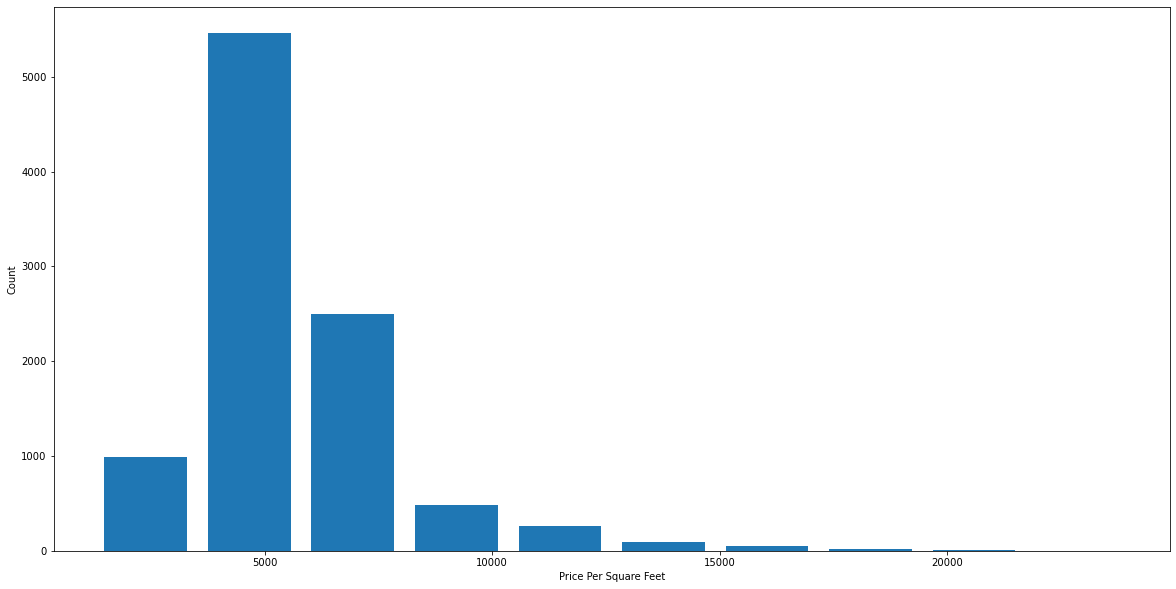

In [34]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df7.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

### Outlier Removal Using Bathrooms Feature


In [35]:
df7.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 13.])

Text(0, 0.5, 'Count')

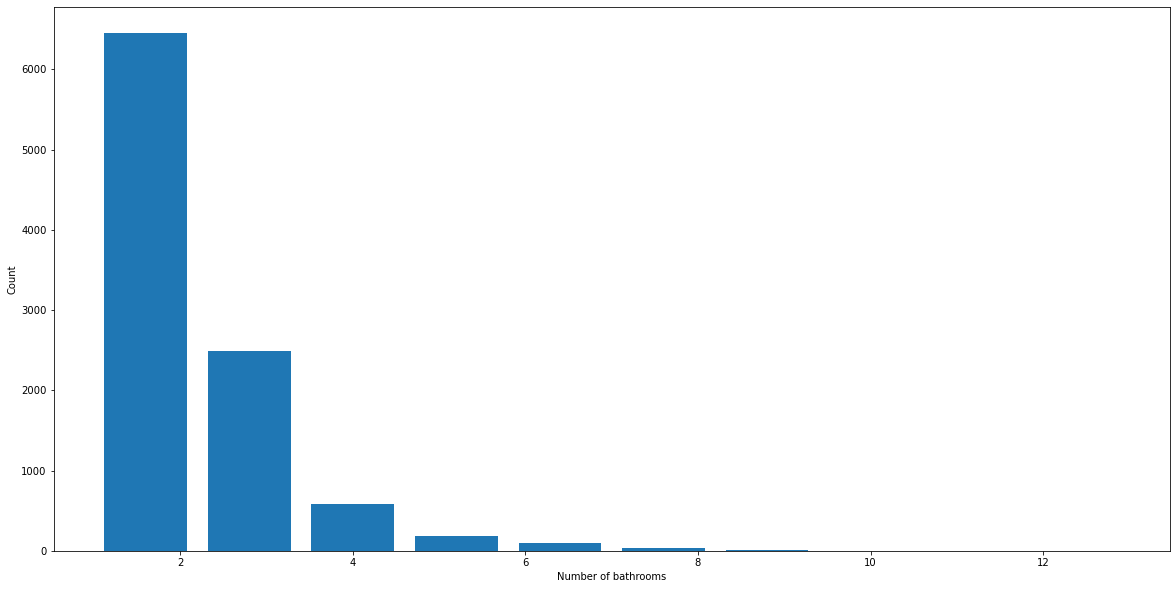

In [36]:
plt.hist(df7.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [37]:
df7[df7.bath>10]

,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
9267,other,13 BHK,5425.0,13.0,0.0,275.0,13,5069.124424


In [38]:
df7[df7.bath>df7.bhk+2]

,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
1542,Chikkabanavar,4 Bedroom,2460.0,7.0,2.0,80.0,4,3252.032520
6443,Thanisandra,3 BHK,1806.0,6.0,2.0,116.0,3,6423.034330
8082,other,6 BHK,11338.0,9.0,1.0,1000.0,6,8819.897689


#### Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed

In [39]:
df9 = df7[df7.bath<df7.bhk+2]
df9.shape

(9771, 8)

In [40]:
df9

,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,1.0,428.00,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,2.0,194.00,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,3.0,235.00,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,0.0,130.00,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,2.0,148.00,2,11983.805668
...,...,...,...,...,...,...,...,...
9847,other,2 BHK,1256.0,2.0,1.0,65.00,2,5175.159236
9848,other,2 BHK,1353.0,2.0,2.0,110.00,2,8130.081301
9849,other,1 Bedroom,812.0,1.0,0.0,26.00,1,3201.970443
9850,other,3 BHK,1440.0,2.0,2.0,63.93,3,4439.583333


In [41]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,balcony,price,bhk
0,1st Block Jayanagar,2850.0,4.0,1.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,2.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,3.0,235.0,3


## Use One Hot Encoding For Location

In [42]:
dummies = pd.get_dummies(df10.location)
dummies

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9850,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [43]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11

,location,total_sqft,bath,balcony,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,1.0,428.00,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,2.0,194.00,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,3.0,235.00,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,0.0,130.00,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,2.0,148.00,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847,other,1256.0,2.0,1.0,65.00,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9848,other,1353.0,2.0,2.0,110.00,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9849,other,812.0,1.0,0.0,26.00,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9850,other,1440.0,2.0,2.0,63.93,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
df12 = df11.drop('location',axis='columns')
df12

,total_sqft,bath,balcony,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,1.0,428.00,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,2.0,194.00,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3.0,235.00,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,0.0,130.00,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2.0,148.00,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847,1256.0,2.0,1.0,65.00,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9848,1353.0,2.0,2.0,110.00,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9849,812.0,1.0,0.0,26.00,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9850,1440.0,2.0,2.0,63.93,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Building a Model

In [45]:
df12.shape

(9771, 240)

In [46]:
X = df12.drop(['price'],axis='columns')
X

,total_sqft,bath,balcony,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,1.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,2.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,0.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847,1256.0,2.0,1.0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9848,1353.0,2.0,2.0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9849,812.0,1.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9850,1440.0,2.0,2.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
y = df12.price
y

0       428.00
1       194.00
2       235.00
3       130.00
4       148.00
         ...  
9847     65.00
9848    110.00
9849     26.00
9850     63.93
9851     48.00
Name: price, Length: 9771, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)
# (X_train)

In [ ]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

### Use K Fold cross validation to measure accuracy of our LinearRegression model

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

In [ ]:
predict_price('1st Phase JP Nagar',1000, 2, 4,3)

We can see that in 5 iterations we get a score nearly 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose

### Find best model using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

#### Based on above results we can say that LinearRegression gives the best score. Hence we will use that.

### Test the model for few properties

In [1]:
def predict_price(location,sqft,bath,balcony,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = balcony
    x[3] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]


In [2]:
predict_price('1st Phase JP Nagar',1000, 2, 1, 4)

NameError: name 'np' is not defined

In [88]:
predict_price('1st Phase JP Nagar',1000, 3, 0 , 4)

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


101.55872551576934

In [89]:
predict_price('Indira Nagar',1000, 2, 2,2)

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


159.76812555937352

## Export the tested model to a pickle file

In [90]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

## Export location and column information to a file that will be useful later on in our prediction application

In [91]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))